# Driving drowsiness detection system based on CNN

## 1. Install the required libraries and getting data

### 1.1 Install requirements

**Here recommened to use anaconda environment if you want to use GPU to run tensorflow.**

`pip install` or `conda install`:
```
numpy
matplotlib
opencv-python 
labelme
albumentations
dilb
```

### 1.2 Using anaconda to install CUDA toolkit and cudnn for Tensorflow2.0: 

```
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
```
Anything above 2.10 is not supported on the GPU on Windows Native
```
python -m pip install "tensorflow<2.11"
```
Verify the installation:
```
python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
```

(From tensorflow official website)

### 1.3 Choose to resize all image in same size or not

In [ ]:
import os
import cv2
import albumentations as alb

def crop_images_in_directory_alb(directory, output_directory, crop_width=224, crop_height=224):

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Define the cropping transform
    transform = alb.Compose([
        alb.SmallestMaxSize(max_size=max(crop_width, crop_height), always_apply=True),
        alb.CenterCrop(height=crop_height, width=crop_width, always_apply=True)
    ])

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        # Check if the file is an image
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Read the image using OpenCV
            image = cv2.imread(file_path)
            if image is None:
                continue  # Skip files that aren't valid images
            
            # Ensure the image is at least as large as the crop size by scaling up if necessary
            height, width, _ = image.shape
            if height < crop_height or width < crop_width:
                scaling_factor = max(crop_height / height, crop_width / width)
                image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            
            # Apply the cropping transformation
            cropped_image = transform(image=image)['image']
            
            # Convert back to BGR from RGB for saving via OpenCV
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
            
            # Save the cropped image to the output directory
            cv2.imwrite(os.path.join(output_directory, filename), cropped_image)


In [ ]:
input_directory = 'data/images'
output_directory = 'data/croppedImg'
crop_images_in_directory_alb(input_directory, output_directory, crop_width=512, crop_height=512)

### 1.4 Get the data and label them

**Used Datasets**:

Face-Detection-Dataset: https://www.kaggle.com/datasets/fareselmenshawii/face-detection-dataset

Flickr_Face-HQ (FFHQ): https://www.kaggle.com/datasets/arnaud58/flickrfaceshq-dataset-ffhq

**Here I'm using labelme to label the data we had, the generated label format is JSON.**

In [ ]:
!labelme

## 2. Import all the libraries and preview data

### 2.1 Import libraries and check GPU

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.python.client import device_lib
import json
import os

In [2]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [3]:
get_available_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 

Num GPUs Available:  1


### 2.3 Preview the image

In [ ]:
# Choose all the .jpg file in the folder
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

- I have two versions of image loading function, first one is the one this project currently using, seconde one can resize all images in same size.

In [ ]:
def load_image(path):
    byte_image = tf.io.read_file(path)
    try:
        img = tf.io.decode_image(byte_image, channels=3)
        return img
    except tf.errors.InvalidArgumentError:
        print("Can't decode the image, the format may not supported.")
        return None
    except tf.errors.NotFoundError:
        print("File not found, please check the path.")
        return None

In [ ]:
# def load_image(path, target_size=(512, 512)):
#     byte_image = tf.io.read_file(path)
#     try:
#         img = tf.io.decode_image(byte_image, channels=3, expand_animations=False)
#         img = tf.image.resize(img, target_size)
#         return img
#     except tf.errors.InvalidArgumentError:
#         print("Can't decode the image, the format may not be supported.")
#         return None
#     except tf.errors.NotFoundError:
#         print("File not found, please check the path.")
#         return None

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

## 3. Manage raw data

### 3.1 Split the data

70% for training
15% for both test and validation

In [ ]:
import shutil

def random_image_splitter(source_dir, target_dir, num_imgs):
    """
    Randomly samples num_imgs images from source_dir and copies them to target_dir.
    """
    
    # Get a list of all files in the source directory
    all_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    
    # Randomly sample files
    sampled_files = np.random.choice(all_files, size=num_imgs, replace=False)
    
    # Cut files to the target directory
    for file in sampled_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

    print(f"Moved {num_imgs} images to {target_dir}")

In [ ]:
dataset_size = 300

In [ ]:
 # Training set
training_num = int(dataset_size * 0.7)
source_directory = 'data/images'
target_directory = 'data/training/images'

random_image_splitter(source_directory, target_directory, training_num)

In [ ]:
# Test set
test_num = int(dataset_size * 0.15)
source_directory = 'data/images'
target_directory = 'data/test/images'

random_image_splitter(source_directory, target_directory, test_num)

In [ ]:
# Validation set
val_num = int(dataset_size * 0.15)
source_directory = 'data/images'
target_directory = 'data/validation/images'

random_image_splitter(source_directory, target_directory, test_num)

### 3.2 Match the labels with coressponding images

In [ ]:
# Define the root directory for the datasets and the labels directory
data_root_dir = 'data'
labels_dir = os.path.join(data_root_dir, 'labels')

data_sub_dirs = ['training', 'test', 'validation']

# Loop through each subdirectory
for sub_dir in data_sub_dirs:
    images_dir = os.path.join(data_root_dir, sub_dir, 'images')
    target_labels_dir = os.path.join(data_root_dir, sub_dir, 'labels')
    
    os.makedirs(target_labels_dir, exist_ok=True)

    # Iterate through each image file in the images subdirectory
    for image_file in os.listdir(images_dir):
        # Construct the corresponding label file name
        label_file_name = os.path.splitext(image_file)[0] + '.json'
        
        # Build the path for the label file
        existing_label_path = os.path.join(labels_dir, label_file_name)
        
        # Move it to the corresponding subdirectory
        if os.path.exists(existing_label_path):
            # Build the new path for the label file
            new_label_path = os.path.join(target_labels_dir, label_file_name)
            
            # Move the label file
            os.replace(existing_label_path, new_label_path)
            print(f"Moved {existing_label_path} to {new_label_path}")
        else:
            print(f"Label file {label_file_name} does not exist in {labels_dir}")

## 4. Do image augemntation to make model more robust

### 4.1 Import albumentations and set up the transform function

In [4]:
import albumentations as alb

In [5]:
transform = alb.Compose([
    # alb.RandomCrop(width=512, height=512),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.2),
    alb.RandomRotate90(p=0.3),
    alb.GaussianBlur(p=0.1),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.GaussNoise(p=0.1),
    alb.RandomBrightnessContrast(p=0.5),
    alb.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Get labels and normlize it

In [6]:
def read_label(label_path):
    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            label = json.load(file)

        # This nedd to be in when extract from json file
        image_width = int(label['imageWidth'])
        image_height = int(label['imageHeight'])

        # Get coords and normalize it
        bbox_coords = label['shapes'][0]['points']
        normalized_bbox = [
            bbox_coords[0][0] / image_width,
            bbox_coords[0][1] / image_height,
            bbox_coords[1][0] / image_width,
            bbox_coords[1][1] / image_height
        ]
        return normalized_bbox
    else:
        return []  # If there is no bbox, return a null list


### 4.3 Augument images and put them  into right folder

In [7]:
def save_augmented_images(img, coords, image_path, partition):
    for x in range(30):
        augmented = transform(image=img, bboxes=[coords], class_labels=['face'])
        augmented_img_path = os.path.join('aug_data', partition, 'images', f'{os.path.splitext(image_path)[0]}.{x}.png')
        cv2.imwrite(augmented_img_path, augmented['image'])
        annotation = {'image': image_path, 'bbox': augmented['bboxes'][0] if augmented['bboxes'] else [0,0,0,0], 'class': 1 if augmented['bboxes'] else 0}
        with open(os.path.join('aug_data', partition, 'labels', f'{os.path.splitext(image_path)[0]}.{x}.json'), 'w') as file:
            json.dump(annotation, file)

In [8]:
def process_images():
    for partition in ['training', 'test', 'validation']:
        img_dir = os.path.join('data', partition, 'images')
        for image in os.listdir(img_dir):
            img_path = os.path.join(img_dir, image)
            img = cv2.imread(img_path)
            label_path = os.path.join('data', partition, 'labels', f'{os.path.splitext(image)[0]}.json')
            coords = read_label(label_path)
            try:
                save_augmented_images(img, coords, image, partition)
            except Exception as e:
                print(e)

In [9]:
process_images()

'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' and 'str'
'<=' not supported between instances of 'int' an

### 4.4 Load Augmented Images to tf dataset

### **CHECK POINT:** If data already pre-processed but model hasn't built, run from here

In [10]:
import cv2
import json
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from matplotlib import pyplot as plt

In [11]:
def load_and_preprocess_image(path):
    """Load an image from a file, resize it, and normalize it."""
    byte_image = tf.io.read_file(path)
    img = tf.io.decode_png(byte_image, channels=3)
    img = tf.image.resize(img, (224, 224))  # resize it to (224,224), standard VGG16 input size.
    img = img / 255.0  # normalize to [0, 1]
    return img

In [12]:
def create_dataset(img_dir):
    """Create a TensorFlow dataset from images in a directory."""
    img_paths = tf.data.Dataset.list_files(f'{img_dir}/*.png', shuffle=False)
    dataset = img_paths.map(load_and_preprocess_image)
    return dataset

In [13]:
# Create datasets
training_images = create_dataset('aug_data/training/images')
test_images = create_dataset('aug_data/test/images')
validation_images = create_dataset('aug_data/validation/images')

In [14]:
training_images.as_numpy_iterator().next()

array([[[0.06464586, 0.06072429, 0.05378151],
        [0.07180872, 0.07152861, 0.0590036 ],
        [0.07815126, 0.07899159, 0.06638656],
        ...,
        [0.39775893, 0.32523   , 0.2627451 ],
        [0.38627443, 0.31344533, 0.2546218 ],
        [0.3750699 , 0.30358136, 0.24705882]],

       [[0.01988795, 0.01970788, 0.0057823 ],
        [0.032513  , 0.03249299, 0.01680672],
        [0.0415166 , 0.04543817, 0.02969187],
        ...,
        [0.40526193, 0.33003193, 0.2664466 ],
        [0.395238  , 0.3170868 , 0.25826326],
        [0.37881142, 0.30952382, 0.24939963]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.4141055 , 0.3341736 , 0.26666668],
        [0.40050012, 0.3257702 , 0.26246494],
        [0.39105633, 0.31316513, 0.2538014 ]],

       ...,

       [[0.03613437, 0.04005594, 0.04789907],
        [0.03899559, 0.05048019, 0.05098039],
        [0.04145667, 0

## 5. Prepare Labels & put image and labels together

### 5.1 Load Labels from path

In [15]:
def load_labels(label_path):
    label_path = label_path.numpy().decode('utf-8')  # Decode to string
    try:
        with open(label_path, 'r', encoding='utf-8') as f:
            label = json.load(f)
        class_label = label['class']
        bbox = label['bbox']
        # class_label is an integer and bbox is a list of floats
        class_label = int(class_label)
        bbox = [float(x) for x in bbox]
    except Exception as e:
        print(f"Error loading labels: {e}")
        # Provide default values in case of an error
        class_label = 0
        bbox = [0.0, 0.0, 0.0, 0.0]
    return [class_label], bbox

### 5.2 Create tf dataset

In [16]:
# Adjusted map call to ensure type safety and error handling
def create_labels_dataset(path_pattern):
    labels = tf.data.Dataset.list_files(path_pattern, shuffle=False)
    labels = labels.map(lambda x: tf.py_function(load_labels, [x], [tf.int32, tf.float32]))
    return labels

In [17]:
training_labels = create_labels_dataset('aug_data/training/labels/*.json')
test_labels = create_labels_dataset('aug_data/test/labels/*.json')
validation_labels = create_labels_dataset('aug_data/validation/labels/*.json')

In [18]:
training_labels.as_numpy_iterator().next()

(array([1]),
 array([0.3613691 , 0.24595717, 0.7957004 , 0.5874126 ], dtype=float32))

### 5.3 Put images and labels together

In [19]:
def prepare_image_and_coords(res, idx, scale=(224, 224)):
    """Prepare image and coordinates for display."""
    # Copy to avoid modification of read-only arrays
    sample_image = np.copy(res[0][idx])
    sample_coords = res[1][1][idx]
    # Calculate start and end points
    start_point = tuple(np.multiply(sample_coords[:2], scale).astype(int))
    end_point = tuple(np.multiply(sample_coords[2:], scale).astype(int))
    # Draw rectangle
    cv2.rectangle(sample_image, start_point, end_point, (255, 0, 0), 2)
    return sample_image

### 5.4 Function for display sample images

In [20]:
def display_images(data_samples, num_images=8):
    """Display images with annotations."""
    res = data_samples.next()
    fig, ax = plt.subplots(ncols=num_images, figsize=(5*num_images, 5))
    for idx in range(num_images):
        img = prepare_image_and_coords(res, idx)
        ax[idx].imshow(img)
    plt.show()

In [21]:
train = tf.data.Dataset.zip((training_images, training_labels))
train = train.shuffle(2505).batch(8).prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(555).batch(8).prefetch(4)
val = tf.data.Dataset.zip((validation_images, validation_labels))
val = val.shuffle(585).batch(8).prefetch(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


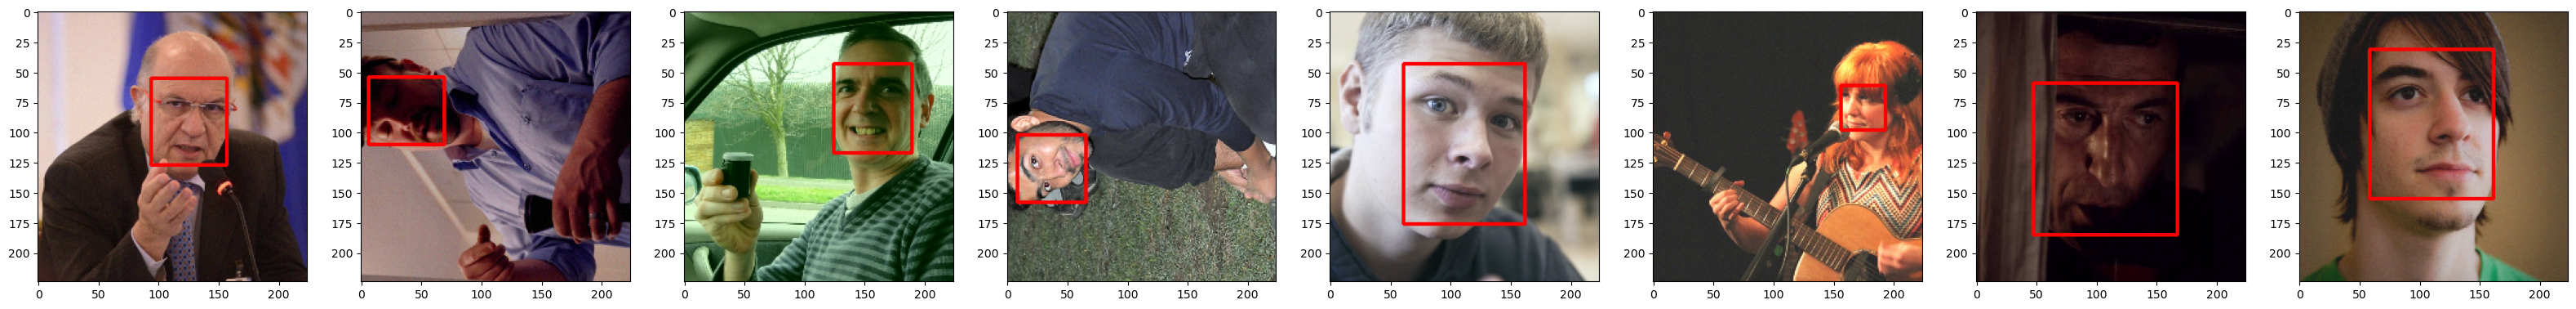

In [22]:
data_samples = train.as_numpy_iterator()
display_images(data_samples)

## 6. Build customized VGG16 model

### 6.1 Import Layers and Base Network

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

### 6.2 Check the structure

In [24]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 6.3 Build model

In [25]:
def build_dense_layer(units, activation, dropout_rate=0.5):
    """ Helper function to create a dense layer with dropout."""
    def layer(x):
        x = Dense(units, activation=activation)(x)
        x = Dropout(dropout_rate)(x) 
        return x
    return layer

In [26]:
def build_vgg(): 
    input_layer = Input(shape=(224, 224, 3))
    vgg_features = VGG16(include_top=False)(input_layer)

    # Apply Global Max Pooling once and reuse it for both branches
    pooled_features = GlobalMaxPooling2D()(vgg_features)

    # Classification branch
    classification_dense = build_dense_layer(2048, 'relu', dropout_rate=0.5)(pooled_features)
    classification_output = build_dense_layer(1, 'sigmoid', dropout_rate=0)(classification_dense)
    
    # Bounding box regression branch
    bbox_dense = build_dense_layer(2048, 'relu', dropout_rate=0.5)(pooled_features)
    bbox_output = build_dense_layer(4, 'sigmoid', dropout_rate=0)(bbox_dense)
    
    dual_task_face_model = Model(inputs=input_layer, outputs=[classification_output, bbox_output], name="DualTaskFaceModel")
    return dual_task_face_model

In [27]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]]),
 array([[0.24049388, 0.08547312, 0.41395324, 0.30673623],
        [0.24322553, 0.11825284, 0.561462  , 0.4747323 ],
        [0.5894613 , 0.35249126, 0.71101946, 0.47951266],
        [0.38322225, 0.33473557, 0.55121833, 0.52185315],
        [0.4358064 , 0.09093641, 0.6884834 , 0.35454   ],
        [0.45219624, 0.28351727, 0.65570366, 0.5785347 ],
        [0.3743444 , 0.26029828, 0.6570695 , 0.5758031 ],
        [0.45765954, 0.03903518, 0.7076049 , 0.29034638]], dtype=float32))

### 6.4 Test Neural Network

In [28]:
DualTaskFaceModel = build_vgg()
DualTaskFaceModel.summary()

Model: "DualTaskFaceModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                      

## 7. Define Losses and Optimizers

### 7.1 Define Optimizer and LR

In [29]:
batches_per_epoch = len(train)
initial_learning_rate=0.00005
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=batches_per_epoch,
    decay_rate=0.9,
    staircase=True)

In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 7.2 Create IOU Loss and Classification Loss

In [31]:
def iou_loss(y_true, y_pred):
    # Calculate the intercet of coords
    inter_x1 = tf.maximum(y_true[:, 0], y_pred[:, 0])
    inter_y1 = tf.maximum(y_true[:, 1], y_pred[:, 1])
    inter_x2 = tf.minimum(y_true[:, 2], y_pred[:, 2])
    inter_y2 = tf.minimum(y_true[:, 3], y_pred[:, 3])
    inter_area = tf.maximum(inter_x2 - inter_x1, 0) * tf.maximum(inter_y2 - inter_y1, 0)
    
    # Calculate the area
    true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])
    
    # Calculate the union area
    union_area = true_area + pred_area - inter_area
    
    # Calculate iou
    iou_loss = inter_area / union_area
    # iou_loss
    return 1 - tf.reduce_mean(iou_loss)

In [32]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = iou_loss

## 8. Train Neural Network

### 8.1 Create Custom Model Class

In [33]:
class FaceDetector(Model): 
    def __init__(self, face_detector_model, loss_weights=(1.0, 0.5), **kwargs): 
        # Initializes the FaceDetector with a base model and loss weights.
        super().__init__(**kwargs)
        self.face_detector = face_detector_model  # The underlying model for face detection.
        self.loss_weights = loss_weights  # Weights for IoU and classification loss.

    def compile(self, optimizer, classification_loss, iou_loss, metrics=[], **kwargs):
        # Configures the model for training with optimizer and loss functions.
        super().compile(optimizer=optimizer, loss=None, metrics=metrics, **kwargs)
        self.classification_loss = classification_loss
        self.iou_loss = iou_loss

    def _compute_losses(self, labels, predictions):
        # Calculates total, classification, and IoU losses.
        loss_classification = self.classification_loss(labels[0], predictions[0])
        loss_iou = self.iou_loss(tf.cast(labels[1], tf.float32), predictions[1])
        total_loss = self.loss_weights[0] * loss_iou + self.loss_weights[1] * loss_classification
        return total_loss, loss_classification, loss_iou

    def train_step(self, batch, **kwargs): 
        # Performs a single step of training.
        images, labels = batch
        with tf.GradientTape() as tape: 
            predictions = self.face_detector(images, training=True)
            total_loss, loss_classification, loss_iou = self._compute_losses(labels, predictions)
            gradients = tape.gradient(total_loss, self.face_detector.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.face_detector.trainable_variables))
        return {"total_loss": total_loss, "classification_loss": loss_classification, "iou_loss": loss_iou}

    def test_step(self, batch, **kwargs): 
        # Evaluates the model on a test batch.
        images, labels = batch
        predictions = self.face_detector(images, training=False)
        total_loss, loss_classification, loss_iou = self._compute_losses(labels, predictions)
        return {"total_loss": total_loss, "classification_loss": loss_classification, "iou_loss": loss_iou}

    def call(self, inputs, **kwargs): 
        # Method for model forwarding.
        return self.face_detector(inputs, **kwargs)


In [34]:
model = FaceDetector(DualTaskFaceModel)
model.compile(opt, classloss, regressloss)

### 8.2 Train

In [35]:
logdir='logs'

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

### 8.3 Set early stopping callback

In [37]:
early_stopper = EarlyStopping(
    monitor='val_total_loss',    
    min_delta=0.001,        
    patience=10,         
    verbose=1,              
    mode='min',         
    restore_best_weights=True 
)

In [38]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25


627/627 [==============================] - 86s 121ms/step - total_loss: 0.7998 - classification_loss: 0.0052 - iou_loss: 0.7972 - val_total_loss: 0.8354 - val_classification_loss: 8.4154e-04 - val_iou_loss: 0.8349
Epoch 2/25
627/627 [==============================] - 73s 112ms/step - total_loss: 0.6354 - classification_loss: 2.6929e-04 - iou_loss: 0.6353 - val_total_loss: 0.3855 - val_classification_loss: 3.8566e-05 - val_iou_loss: 0.3855
Epoch 3/25
627/627 [==============================] - 73s 114ms/step - total_loss: 0.4718 - classification_loss: 1.0339e-04 - iou_loss: 0.4718 - val_total_loss: 0.4104 - val_classification_loss: 1.3709e-06 - val_iou_loss: 0.4104
Epoch 4/25
627/627 [==============================] - 74s 114ms/step - total_loss: 0.3787 - classification_loss: 4.7287e-05 - iou_loss: 0.3786 - val_total_loss: 0.3492 - val_classification_loss: 4.7088e-06 - val_iou_loss: 0.3492
Epoch 5/25
627/627 [==============================] - 74s 115ms/step - total_loss: 0.3319 - classif

### 8.4 Plot Performance

In [39]:
hist.history

{'total_loss': [0.5256256461143494,
  0.4445573687553406,
  0.4420633018016815,
  0.22886869311332703,
  0.5553978681564331,
  0.19514620304107666,
  0.21677649021148682,
  0.23808854818344116,
  0.32846128940582275,
  0.22082793712615967,
  0.25174129009246826,
  0.14151811599731445,
  0.17590075731277466,
  0.12510442733764648,
  0.10890090465545654,
  0.277671217918396,
  0.15483367443084717,
  0.07259613275527954,
  0.1470247507095337,
  0.18619346618652344,
  0.20946326851844788,
  0.37697291374206543,
  0.19694387912750244,
  0.11061674356460571,
  0.31709742546081543],
 'classification_loss': [0.0011106558376923203,
  1.1920930376163597e-07,
  9.95793889160268e-05,
  2.0921483155689202e-05,
  7.033821748336777e-05,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  2.3841863594498136e-07,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  2.6822162908501923e-06,
  -0.0,
  -0.0,
  -0.0,
  -0.0],
 'iou_loss': [0.525070309638977,
  0.4445573091506958,
  0.442013502120

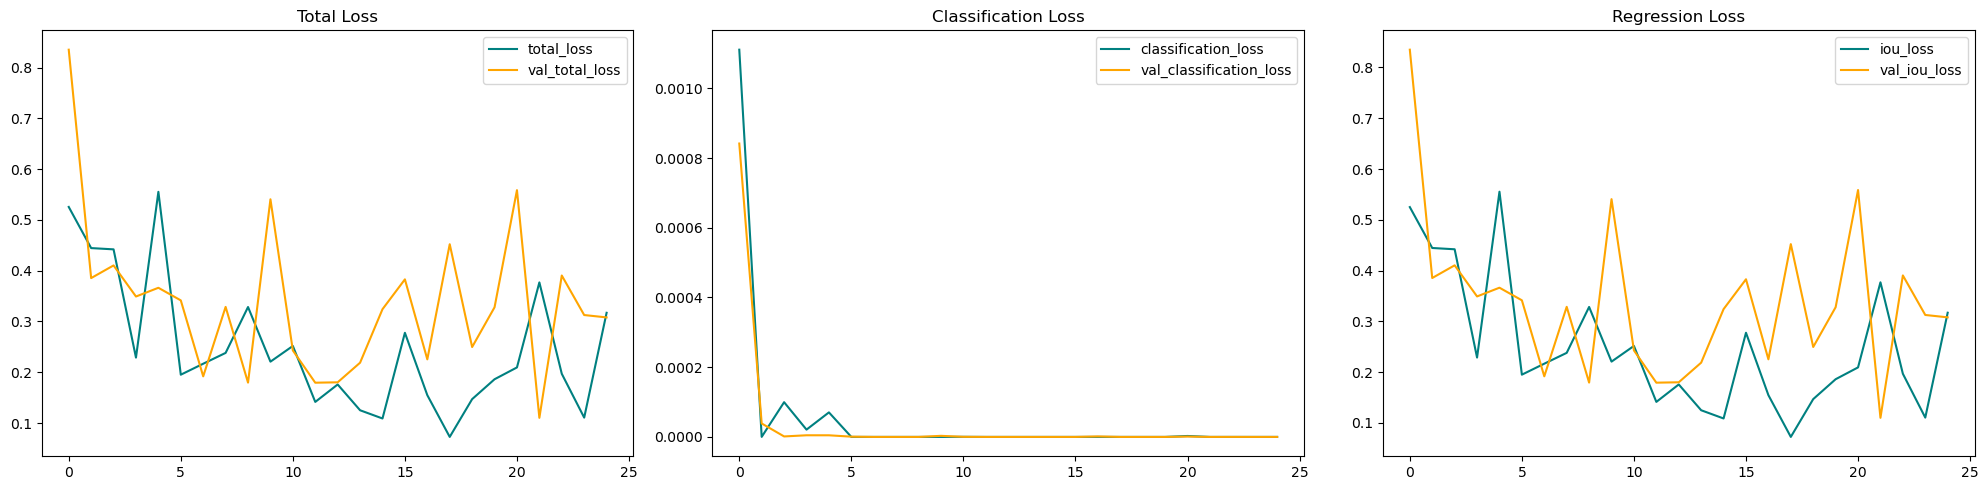

In [40]:
# Create a figure with subplots arranged in a row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Titles for each subplot
titles = ['Total Loss', 'Classification Loss', 'Regression Loss']

# Data to plot for each axis
metrics = [
    ('total_loss', 'val_total_loss'),
    ('classification_loss', 'val_classification_loss'),
    ('iou_loss', 'val_iou_loss')
]

# Colors for training and validation lines
colors = ['teal', 'orange']

# Loop through each axis, set titles, plot data, and configure legends
for ax, title, (train_metric, val_metric) in zip(axes, titles, metrics):
    ax.plot(hist.history[train_metric], color=colors[0], label=train_metric)
    ax.plot(hist.history[val_metric], color=colors[1], label=val_metric)
    ax.set_title(title)
    ax.legend()

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

## 9. Make Predictions

### 9.1 Make Predictions on Test Set

In [41]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [42]:
y_pred = DualTaskFaceModel.predict(test_sample[0])

1/1 [==============================] - 0s 150ms/step


In [43]:
len(training_images)

5010

1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


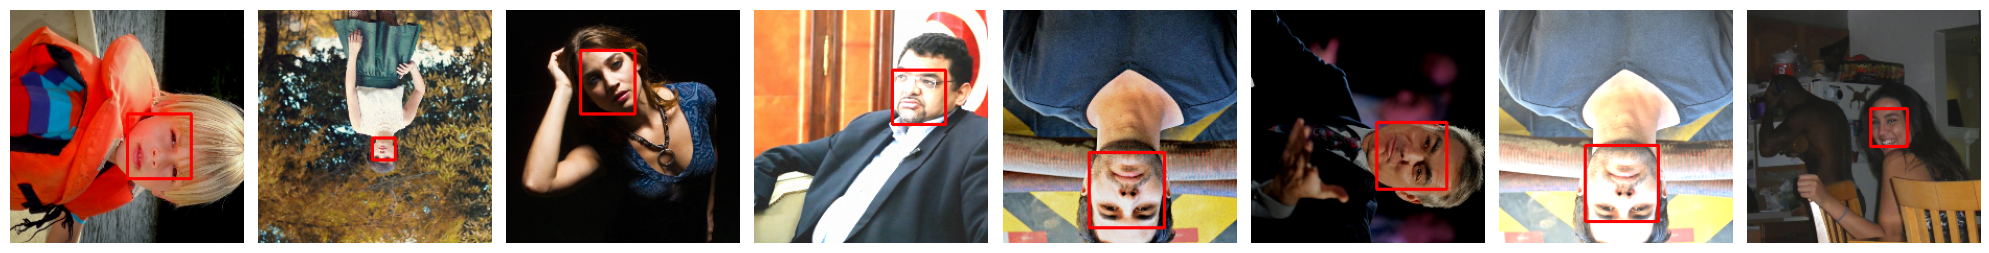

In [52]:
test_sample = test_data.next()
y_pred = DualTaskFaceModel.predict(test_sample[0])

fig, axes = plt.subplots(ncols=8, figsize=(20, 10))  

for idx, ax in enumerate(axes):
    sample_image = np.copy(test_sample[0][idx])
    
    sample_coords = y_pred[1][idx]
    confidence = y_pred[0][idx]

    # Check if the prediction confidence is higher than 0.9
    if confidence > 0.9:
        # Scale the coordinates back to the original image size (224, 224) and convert to integers
        start_point = tuple(np.multiply(sample_coords[:2], [224, 224]).astype(int))
        end_point = tuple(np.multiply(sample_coords[2:], [224, 224]).astype(int))
        
        # Draw a rectangle on the image using the predicted coordinates
        cv2.rectangle(sample_image, start_point, end_point, (255, 0, 0), 2)  # Red rectangle with thickness 2

    ax.imshow(sample_image)  # Convert BGR to RGB for correct color display
    ax.axis('off')  # Hide axis for cleanliness

# Display all subplots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### 9.2 Save the Model

In [53]:
DualTaskFaceModel.save('DualTaskFaceModel.h5')

## 10 Implement driving drowsiness detection

### CHECK POINT: 10.1 If model was built, trained and saved, execute from here. 

**NOTE**: Because of using jupyter note book, all the helper fuctions or classes have to run on to of the main loop, so the order here can't describe the development order perfectly.

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
import dlib
import cv2
import time
import pygame

pygame 2.2.0 (SDL 2.30.2, Python 3.9.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 10.2 Load saved model

In [57]:
DualTaskFaceModel = tf.keras.models.load_model('DualTaskFaceModel.h5')

### 10.3 Load dlib's face landmark predictor

In [59]:
predictor = dlib.shape_predictor('asserts/shape_predictor_68_face_landmarks.dat')

### 10.4 Init all the variables that needed for main loop

In [60]:
blink_count = 0
eyes_closed = False
zoom_factor = 0.0

pygame.init()
alert_sound = pygame.mixer.Sound('asserts/alert_sound.mp3')

### 10.5 Get eyes landmarks from all 68 points

In [61]:
def extract_important_landmarks(landmarks):
    important_points = {
        "left_eye": [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)],
        "right_eye": [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)],
        "mouth": [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)]
    }
    return important_points

### 10.6 Calculate eye aspect ratio(EAR) using this formula:

$$EAR = \frac{||p_2-p_6||+||p_3-p_5||}{2||p_1-P_4||}$$

In [62]:
def EAR(marks):
    # marks is expected to be a list of tuples [(x1, y1), (x2, y2), ..., (x6, y6)]
    
    # Convert to a numpy array
    marks = np.array(marks)
    
    # Calculate vertical distances
    vert_dis1 = np.linalg.norm(marks[1] - marks[5])
    vert_dis2 = np.linalg.norm(marks[2] - marks[4])
    
    # Calculate horizontal distance
    hor_dis = np.linalg.norm(marks[0] - marks[3])
    
    # Calculate EAR
    ear = (vert_dis1 + vert_dis2) / (2.0 * hor_dis)
    
    return ear

### 10.7 Make the movement of bbox smooth

Since the bounding box drawn by face detection model is shaking a bit in realtime, this will effect a lot on facial landmark predection, so here I'm getting the average value to make the movement of bbox smooth.

In [63]:
class BoundingBoxSmoother:
    def __init__(self, max_frames=5):
        self.max_frames = max_frames
        self.boxes = []

    def update(self, box):
        self.boxes.append(box)
        if len(self.boxes) > self.max_frames:
            self.boxes.pop(0)
        return self.get_smoothed_box()

    def get_smoothed_box(self):
        if not self.boxes:
            return None
        avg_box = [0, 0, 0, 0]
        for box in self.boxes:
            for i in range(4):
                avg_box[i] += box[i]
        avg_box = [int(coord / len(self.boxes)) for coord in avg_box]
        return avg_box

In [64]:
smoother = BoundingBoxSmoother(max_frames=5)

### 10.8 Normalize the shape of bounding box

In [65]:
def make_square_box(box):
    x1, y1, x2, y2 = box
    box_width = x2 - x1
    box_height = y2 - y1
    box_size = max(box_width, box_height)
    
    # Calculate new x and y with same box center
    center_x = x1 + box_width / 2
    center_y = y1 + box_height / 2
    
    new_x1 = int(center_x - box_size / 2)
    new_y1 = int(center_y - box_size / 2)
    new_x2 = int(center_x + box_size / 2)
    new_y2 = int(center_y + box_size / 2)
    
    # Make sure new coords can't exceed the edge of image
    new_x1 = max(new_x1, 0)
    new_y1 = max(new_y1, 0)
    new_x2 = min(new_x2, 511)
    new_y2 = min(new_y2, 511)
    
    return [new_x1, new_y1, new_x2, new_y2]

###  10.9 Set up the mechanism for drowsiness or fatigue detection

In [66]:
class FatigueDetector:
    def __init__(self, min_blinks_per_minute=12, blink_duration_threshold=0.33, rate_time_window=60, duration_time_window=120):
        self.min_blinks_per_minute = min_blinks_per_minute
        self.blink_duration_threshold = blink_duration_threshold
        self.rate_time_window = rate_time_window
        self.duration_time_window = duration_time_window
        self.blinks = 0
        self.start_time_rate = time.time()
        self.start_time_duration = time.time()
        self.last_blink_time = None
        self.eyes_closed = False
        self.blink_durations = []
        self.current_alert = ""

    def update(self, eyes_closed):
        current_time = time.time()

        # In 60 seconds, if the blink frequency of driver lower than average, trigger the alert.
        if current_time - self.start_time_rate > self.rate_time_window:
            if self.blinks < self.min_blinks_per_minute * (self.rate_time_window / 60):
                alert_sound.play()
                self.current_alert = f"Low Blink Rate Alert: Only {self.blinks} blinks in the last {self.rate_time_window} seconds."
            self.start_time_rate = current_time
            self.blinks = 0

        # In 120 seconds, if more than 50% of a single eye closure duration is too long, trigger the alert.
        if current_time - self.start_time_duration > self.duration_time_window:
            excessive_duration_count = sum(1 for duration in self.blink_durations if duration > self.blink_duration_threshold)
            excessive_ratio = excessive_duration_count / max(len(self.blink_durations), 1)
            if excessive_ratio > 0.5:
                alert_sound.play()
                self.current_alert = f"Excessive Long Blinks Alert: {excessive_ratio:.2f} of blinks were too long in the last {self.duration_time_window} seconds."
            self.start_time_duration = current_time
            self.blink_durations = []

        if eyes_closed:
            if not self.eyes_closed:
                self.eyes_closed = True
                self.last_blink_time = current_time
        else:
            if self.eyes_closed:
                self.eyes_closed = False
                if self.last_blink_time:
                    blink_duration = current_time - self.last_blink_time
                    self.blink_durations.append(blink_duration)

                    # A realtime reminder, not alert
                    if blink_duration > self.blink_duration_threshold:
                        # alert_sound.play()
                        self.current_alert = f"Long Blink Duration: {blink_duration:.2f}s was observed."
                    self.blinks += 1
                    self.last_blink_time = None

    def get_alerts(self):
        return self.current_alert

In [67]:
fatigue_detector = FatigueDetector()

### 10.10 Main loop, realtime detection

In [1]:
capture = cv2.VideoCapture(0)

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        break

    height, width = frame.shape[:2]
    new_width = int(width * (1 - zoom_factor))
    new_height = int(height * (1 - zoom_factor))
    start_x = width // 2 - new_width // 2
    start_y = height // 2 - new_height // 2

    # Zoom the frame for better accuracy
    cropped_frame = frame[start_y:start_y + new_height, start_x:start_x + new_width]
    zoomed_frame = cv2.resize(cropped_frame, (width, height), interpolation=cv2.INTER_LINEAR)
    rgb_image = cv2.cvtColor(zoomed_frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb_image, (224, 224))


    y_pred = DualTaskFaceModel.predict(np.expand_dims(resized / 255, 0), verbose=0)

    sample_coords = y_pred[1][0]

    if y_pred[0] > 0.5:
        x1, y1, x2, y2 = np.multiply(sample_coords, [width, height, width, height]).astype(int)
        
        smoothed_box = smoother.update([x1, y1, x2, y2])  # 使用平滑函数
        x1, y1, x2, y2 = smoothed_box
        
        predicted_box = [x1, y1, x2, y2]
        square_box = make_square_box(predicted_box)
        x1, y1, x2, y2 = square_box
        
        dlib_rect = dlib.rectangle(left=x1, top=y1, right=x2, bottom=y2)
        landmarks = predictor(rgb_image, dlib_rect)
        
        # important_points = extract_important_landmarks(landmarks)
        # print("Important landmarks:", important_points)

        # Extract landmarks for eyes
        left_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
        right_eye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
        left_eye_EAR = EAR(left_eye)
        right_eye_EAR = EAR(right_eye)

        # Threshold for detecting closed eyes
        ear_threshold = 0.27
        if left_eye_EAR < ear_threshold or right_eye_EAR < ear_threshold:
            if not eyes_closed:
                blink_count += 1
                eyes_closed = True
            print(f"Blink count: {blink_count}")
        else:
            eyes_closed = False

        if left_eye_EAR < ear_threshold or right_eye_EAR < ear_threshold:
            fatigue_detector.update(True)
        else:
            fatigue_detector.update(False)

        # Draw bounding box
        cv2.rectangle(zoomed_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # Draw landmarks
        landmarks_points = []
        for n in range(68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(zoomed_frame, (x, y), 1, (0, 255, 0), -1)
            landmarks_points.append((x, y))
        
        # Example: Print the coordinates of the first landmark
        # print("Coordinates of the first landmark:", landmarks_points[0])


        alerts = fatigue_detector.get_alerts()
        if alerts:
            cv2.putText(zoomed_frame, alerts, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(zoomed_frame, f"Blinks: {fatigue_detector.blinks}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    cv2.imshow('FaceTrack', zoomed_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [3]:
!pip install opencv-python


  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
